<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/05_tranfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning

In this section, we are going to:
* Introduce **fine-tuning transfer learning** with Tensorflow
* Introduce the **KerasFunctional API** to build models
* Using small dataset to experiment faster(eg. 10% of training data)
* **Data Augumentation**
* Running a series of experiments on our Food Vision data
* Introduce the **Model Checkpoint** callback

In [1]:
# check if we're using gpu
! nvidia-smi

Wed Jan 24 16:19:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating Helper Functions

This script was gotten from the Deep Learning with TensorFlow Course repo at this [link](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py)

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-24 16:19:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-24 16:19:56 (77.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

##  Let's get the data

This time we're going to see how to use the pre-trained models in `tf.keras.applications` and apply them to our problem.

In [4]:
# get 10% of training data from the food_10_classes dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-24 16:20:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 142.250.107.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2024-01-24 16:20:03 (193 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check out the number of images and sub-directories
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [6]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train/"
test_dir ="10_food_classes_10_percent/test/"


In [7]:
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# creating the training and testing datasets
train_dataset_10_percent = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_dataset_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
class_names = train_dataset_10_percent.class_names

In [10]:
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# see  a sample batch of data
for images, labels in train_dataset_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.93627548e+02 2.09627548e+02 2.06627548e+02]
   [1.83280609e+02 1.99280609e+02 1.96280609e+02]
   [1.75219391e+02 1.90790817e+02 1.90005096e+02]
   ...
   [1.05943878e+02 1.23943878e+02 1.35943878e+02]
   [1.06193863e+02 1.24193863e+02 1.36193863e+02]
   [1.02127495e+02 1.20127495e+02 1.32127487e+02]]

  [[1.95005096e+02 2.11005096e+02 2.08005096e+02]
   [1.81704071e+02 1.97704071e+02 1.94704071e+02]
   [1.78698990e+02 1.94270416e+02 1.93484695e+02]
   ...
   [1.06433708e+02 1.24433708e+02 1.36433716e+02]
   [1.04586723e+02 1.22586723e+02 1.34586731e+02]
   [1.05836807e+02 1.23836807e+02 1.35836807e+02]]

  [[1.91448990e+02 2.08091843e+02 2.04448990e+02]
   [1.81969391e+02 1.97969391e+02 1.94969391e+02]
   [1.76142853e+02 1.91760208e+02 1.90500000e+02]
   ...
   [1.18336723e+02 1.36336716e+02 1.48336716e+02]
   [1.12265266e+02 1.30265259e+02 1.42265259e+02]
   [1.06020370e+02 1.24020370e+02 1.36020370e+02]]

  ...

  [[1.14994904e+02 1.10994904e+02 1.09994904e+02]
   [1

## The TensorFlow Functional API
Building a transfer learning model using the Functional API

In [12]:
from posixpath import dirname
# 1. Create a model
base_model = keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so underlying pre-trained layers aren't updated)
base_model.trainable=False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')

#4. Rescaling the input
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# EfficientNetB0 doesn't require rescaling
# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pools the outputs of the base model(aggregates all the most important information, reduces computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after passing inputs GlobalAveragePooling2D layer: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit the model
hist_0 = model_0.fit(
    train_dataset_10_percent,
    epochs=5,
    steps_per_epoch=len(train_dataset_10_percent),
    validation_data=test_dataset,
    validation_steps=int(0.25 * len(test_dataset)),
    callbacks=[create_tensorboard_callback(
        dir_name='transfer_learning',
        experiment_name='10_percent_feature_extraction'
    )]
)

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after passing inputs GlobalAveragePooling2D layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240124-162020
Epoch 1/5
24/24 [==============================] - 23s 269ms/step - loss: 1.8507 - accuracy: 0.4413 - val_loss: 1.2850 - val_accuracy: 0.7648
Epoch 2/5
24/24 [==============================] - 4s 173ms/step - loss: 1.0995 - accuracy: 0.7627 - val_loss: 0.8346 - val_accuracy: 0.8487
Epoch 3/5
24/24 [==============================] - 4s 142ms/step - loss: 0.7916 - accuracy: 0.8360 - val_loss: 0.6690 - val_accuracy: 0.8668
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6430 - accuracy: 0.8667 - val_loss: 0.5905 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 4s 173ms/step - loss: 0.5485 - accuracy: 0.8853 - val_loss: 0.5480 - val_accuracy: 0.8

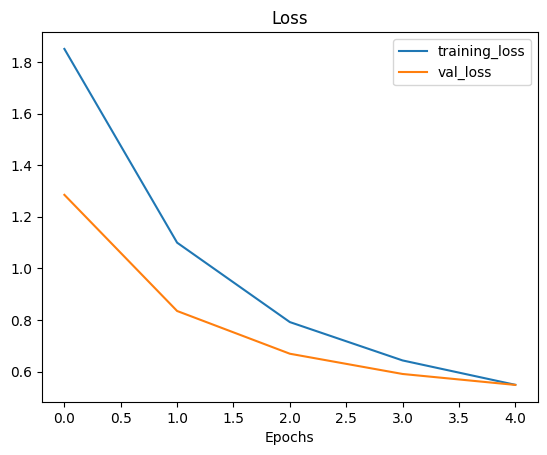

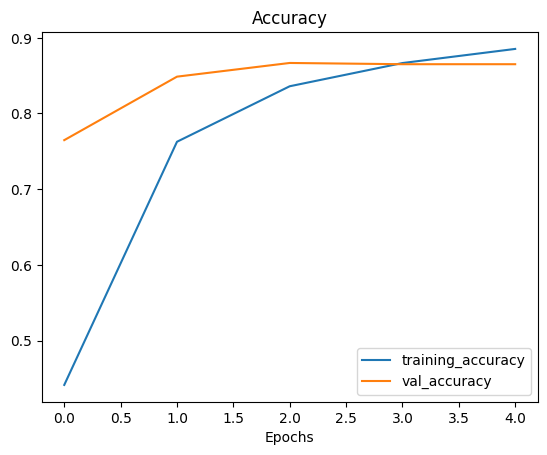

In [13]:
plot_loss_curves(hist_0)

In [14]:
# Evaluate on full test dataset
model_0.evaluate(test_dataset)

79/79 [==============================] - 6s 75ms/step - loss: 0.5539 - accuracy: 0.8632


[0.553894579410553, 0.8632000088691711]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


## Getting a feature vector from a trained model
Let's demonstrate the GlobalAveragePoling2D layer

We have a tensor of shape (None, 7, 7, 1280) after our model goes through `base_model`.

But when it passes thtough the GlobalAveragePooling2D layers, it turns into (None, 1280)

Let's use a similar shape tensor of shape (1, 4, 4, 3) and pass it to the GlobalAveragePooling2D.

In [18]:
# Define the input_shape
input_shape = (1, 4, 4, 3)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338894,  0.97772694],
         [ 0.24694404,  0.20573746, -0.52562326],
         [ 0.32410017,  0.02545409, -0.10638496],
         [-0.63694745,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815628,  0.23479679, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [19]:
# Pass the tensor into a GlobalAveragePooling2D layer
global_average_pool_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pool_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
global_average_pool_tensor.shape

TensorShape([1, 3])

In [21]:
reduced_mean = tf.reduce_mean(input_tensor, axis=[1,2])
global_average_pool_tensor == reduced_mean

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

In [22]:
# Trying the same procedure as above but with GlobalMaxPool2D
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pool_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [23]:
reduced_max = tf.reduce_max(input_tensor, axis=[1,2])
global_max_pool_tensor == reduced_max

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

🖊 A feature vector is a compressed version of the input data based on how the model sees it

## Running series of transfer learning experiments

1. `model_1` - use feature extraction and data augumentation transfer learning with 1% of training data.

2. `model_2` - use feature extraction and data augumentation transfer learning with 10% of training data.

3. `model_3` - use fine-tuning transfer learning on 10% training data with data augumentation

4. `model_4` - use fine-tuning transfer learning on 100% training data with data augumentation

🖊: All experiments will be using the same dataset to ensure consistency.

In [24]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-01-24 16:21:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  65.1MB/s    in 2.0s    

2024-01-24 16:21:16 (65.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# Create training and test directories
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir_1_percent = '10_food_classes_1_percent/test/'

In [26]:
# walk through directory
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [27]:
# setup dataset
train_dataset_1_percent = image_dataset_from_directory(
    directory=train_dir_1_percent,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_dataset_1_percent = image_dataset_from_directory(
    directory=test_dir_1_percent,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augumentation right in the model

In [31]:
import tensorflow as tf
import keras
from keras import layers

# create data augumentation stage with horizontal flipping, rotations, zooms, etc
data_augumentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # No need to rescale since efficientnet b0 has a rescaling layer
])

## Testing the augumentton layer and visualizing

Text(0.5, 1.0, 'Augumented image')

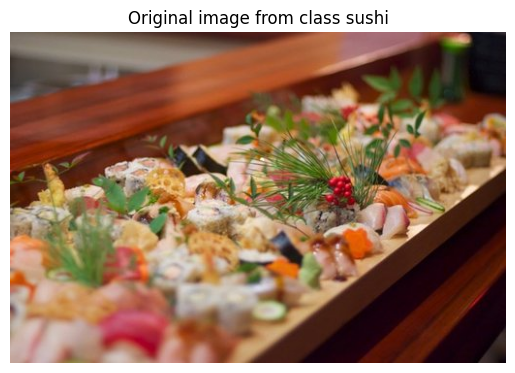

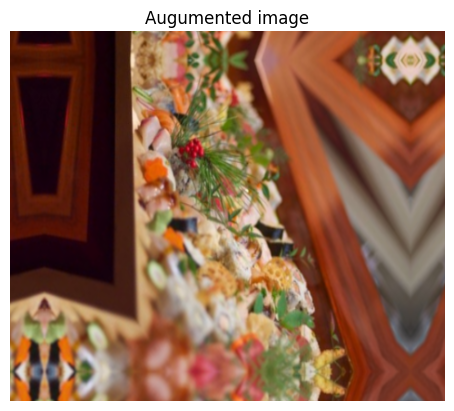

In [34]:
# view a random image and compare to its augumented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_dataset_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
image_path = target_dir + '/' + random_image
# image_path
# load the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original image from class {target_class}')

# augument the image
augumented_image = data_augumentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augumented_image)/255)
plt.axis('off')
plt.title("Augumented image")

## Model 1 : Feature extraction and data augumentation transfer learning with 1% of training data.


In [36]:
# setup input shape and base model, freeze base_model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the input layer
inputs = layers.Input(shape=input_shape, name='input_layer')
# add data augumentation layer
x = data_augumentation(inputs)
# give base model inputs after augumentation and don't train
x = base_model(x, training=False)
# pool output feature of base_model
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)  # inputs are passed to layers outside their parenthesis, while for whole models inputs are passed inside
# put a dense layer as the output
outputs = layers.Dense(10, activation='softmax')(x)

# make a model
model_1 = keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# fit
hist_1_percent = model_1.fit(train_dataset_1_percent,
                             steps_per_epoch=len(train_dataset_1_percent),
                             epochs=5,
                             validation_data=test_dataset_1_percent,
                             validation_steps=(.25 * len(test_dataset_1_percent)),
                             callbacks=[create_tensorboard_callback(
                                 dir_name="transfer_learning",
                                 experiment_name='1_percent_feature_extraction_data_aug'
                             )])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction_data_aug/20240124-165636
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.1920 - val_accuracy: 0.2094
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 2.1074 - accuracy: 0.2571 - val_loss: 2.0779 - val_accuracy: 0.2641
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8919 - accuracy: 0.3857 - val_loss: 1.9727 - val_accuracy: 0.3547
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7357 - accuracy: 0.4857 - val_loss: 1.8735 - val_accuracy: 0.4047
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5620 - accuracy: 0.6429 - val_loss: 1.7893 - val_accuracy: 0.4547


In [37]:
model_1.evaluate(test_dataset_1_percent)

79/79 [==============================] - 8s 87ms/step - loss: 1.7716 - accuracy: 0.4668


[1.7715840339660645, 0.4668000042438507]

In [38]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (5

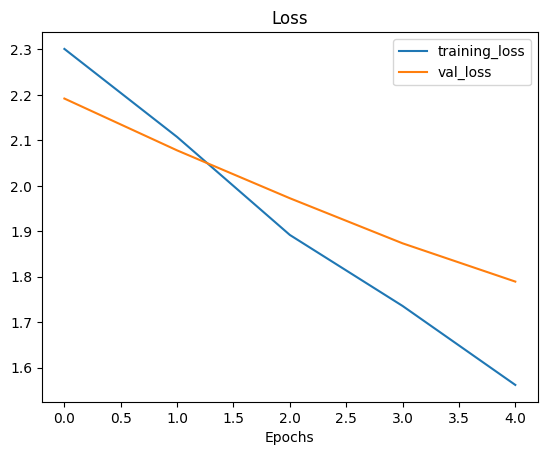

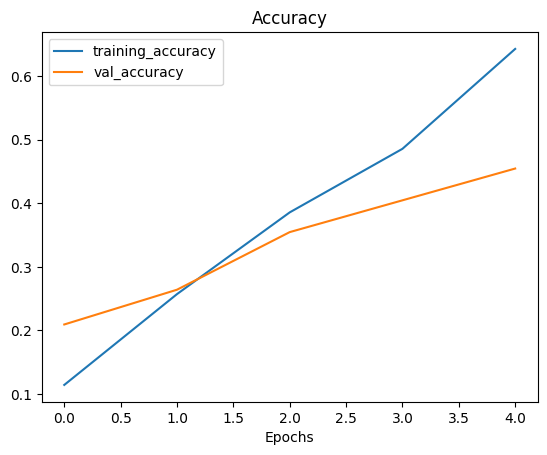

In [39]:
plot_loss_curves(hist_1_percent)